This is a version of object detection that goes through the thought process more in depth.

Step 1. Setting up dependencies and then loading the Input image/s

In [25]:
# import dependencies 
import torch
import torchvision
import sys
import numpy as np
import matplotlib.pyplot as plt
import cv2
%matplotlib inline
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import pylab
pylab.rcParams['figure.figsize'] = (8.0, 10.0)

In [2]:
import os 
os.environ ['KMP_DUPLICATE_LIB_OK'] = 'True'
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [3]:
# OPTIONAL: show annotations on image
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    

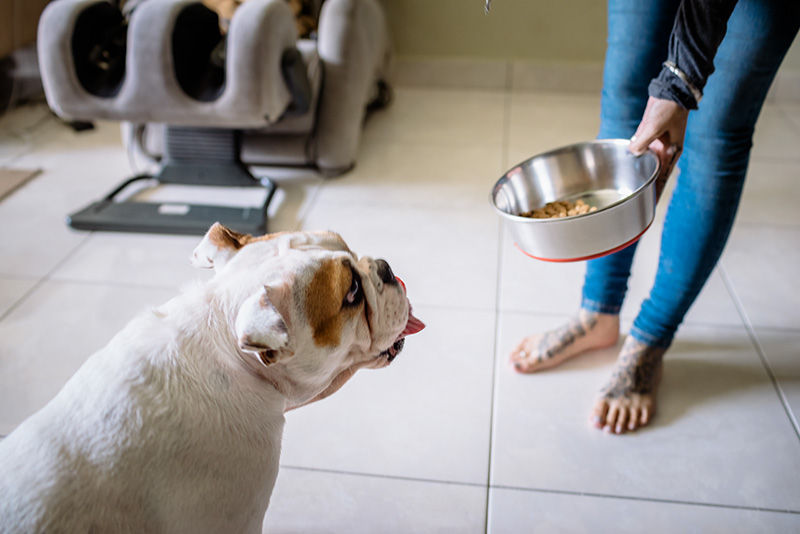

In [4]:
# Our Input: Image
from IPython.display import Image
Image('images/dog.jpg')

Step 2. Segment Anything Output

In [5]:
# Loading SAM Model
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "../sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

# Loading SAM Predictor
mask_generator = SamAutomaticMaskGenerator(sam)

In [8]:
# Get the masks for the image
image = cv2.imread('images/dog.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [9]:
# Run automatic mask generation
masks = mask_generator.generate(image)

In [6]:
# Loading OpenCLIP
import torch
from PIL import Image
import open_clip

model, _, transform = open_clip.create_model_and_transforms(
  model_name="coca_ViT-L-14",
  pretrained="mscoco_finetuned_laion2B-s13B-b90k"
)

In [28]:
# Loading COCO

dataDir='..'
dataType='test2017'
annFile='{}/coco/annotations/{}.json'.format(dataDir,dataType)

In [29]:
# initialize COCO api for instance annotations
coco=COCO(annFile)

loading annotations into memory...
Done (t=0.14s)
creating index...
index created!


In [30]:
# display COCO categories and supercategories
cats = coco.loadCats(coco.getCatIds())
nms=[cat['name'] for cat in cats]
print('COCO categories: \n{}\n'.format(' '.join(nms)))

nms = set([cat['supercategory'] for cat in cats])
print('COCO supercategories: \n{}'.format(' '.join(nms)))

COCO categories: 
person bicycle car motorcycle airplane bus train truck boat traffic light fire hydrant stop sign parking meter bench bird cat dog horse sheep cow elephant bear zebra giraffe backpack umbrella handbag tie suitcase frisbee skis snowboard sports ball kite baseball bat baseball glove skateboard surfboard tennis racket bottle wine glass cup fork knife spoon bowl banana apple sandwich orange broccoli carrot hot dog pizza donut cake chair couch potted plant bed dining table toilet tv laptop mouse remote keyboard cell phone microwave oven toaster sink refrigerator book clock vase scissors teddy bear hair drier toothbrush

COCO supercategories: 
person outdoor food appliance vehicle sports accessory indoor kitchen animal furniture electronic


In [20]:
# Define a list of labels
labels = ["cat", "dog", "person", "bowl"]

# Tokenize the labels
labels_tokenized = open_clip.tokenize(["This is " + desc for desc in labels])

# Run through all the masks and then crop image to ask OpenClip "This is a photo of what?"
length_masks = len(masks)
for mask in range(length_masks): 
    # crop the image AKA get the bounding box
    bbox_xywh = masks[mask]['bbox'] # the SAM model returns the bounding box in xywh format
    bbox_lurd = [bbox_xywh[0], bbox_xywh[1], bbox_xywh[0] + bbox_xywh[2], 
    bbox_xywh[1] + bbox_xywh[3]] # convert the bounding box to LURD format
    cropped_image = im.crop(bbox_lurd) # Crop the image using the bounding box coordinates
    cropped_image.convert("RGB")
    cropped_image = transform(cropped_image).unsqueeze(0)
    
    # ask OpenClip "This is a photo of what?"
    with torch.no_grad(), torch.cuda.amp.autocast():
        image_features = model.encode_image(cropped_image).float()
        text_features = model.encode_text(labels_tokenized).float()
    
    # Normalize the features and calculate the dot product of each pair.
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T
    
    # Get the predicted label
    predicted_label_index = similarity.argmax()
    predicted_label = labels[predicted_label_index]
    
    # get the top 2 probabilities and labels
    text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
    top_probs, top_labels = text_probs.cpu().topk(2, dim=-1)
    
    print("argmax: ", predicted_label)
    print("top_probs: ", top_probs)
    print("top_labels: ", top_labels)

argmax:  dog
top_probs:  tensor([[9.9893e-01, 8.6219e-04]])
top_labels:  tensor([[1, 2]])
argmax:  dog
top_probs:  tensor([[0.9233, 0.0674]])
top_labels:  tensor([[1, 3]])
argmax:  bowl
top_probs:  tensor([[0.9569, 0.0430]])
top_labels:  tensor([[3, 2]])
argmax:  bowl
top_probs:  tensor([[9.9980e-01, 1.9304e-04]])
top_labels:  tensor([[3, 2]])


KeyboardInterrupt: 

In [23]:
im = Image.open("images/dog.jpg")
bbox_xywh = masks[2]['bbox']
print(bbox_xywh)

# Convert the bounding box to LURD format
bbox_lurd = [bbox_xywh[0], bbox_xywh[1], bbox_xywh[0] + bbox_xywh[2],bbox_xywh[1] + bbox_xywh[3]]
print(bbox_lurd)

[582, 0, 217, 347]
[582, 0, 799, 347]


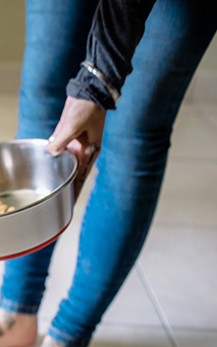

In [24]:
cropped_image = im.crop(bbox_lurd) # Crop the image using the bounding box coordinates
cropped_image.convert("RGB")

Step 3. Crop images for each mask

Step 4. Use CLIP to label the mask : clip_label

Step 5. Compare clip_label to COCO

In [ ]:
# If clip_label in COCO: Compare the prediction with ground truth Score using mAP -> get ground score
# Else: Ignore